# Import Library and Dataset

In [ ]:
#import library
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
from sklearn import preprocessing
from sklearn.cluster import KMeans

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Project Data Science/Analyzing Product Sales - Kalbe Nutritionals')

#import dataset
pd.set_option('display.max_columns', None)
df_transaction = pd.read_csv('Case Study - Transaction.csv', sep=';')
df_store = pd.read_csv('Case Study - Store.csv', sep=';')
df_customer = pd.read_csv('Case Study - Customer.csv', sep=';')
df_product = pd.read_csv('Case Study - Product.csv', sep=';')

Mounted at /content/drive


### Cek Data

In [ ]:
df_transaction.head(3)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4


In [ ]:
df_store.head(3)

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238
2,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529


In [ ]:
df_customer.head(3)

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17


In [ ]:
df_product.head(3)

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500


#Data Cleansing

In [ ]:
#change data type feature 'Date'
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

#change , into .
#df_store['Latitude'] = df_store['Latitude'].replace(',', '.', regex=True).astype('float')
#df_store['Longitude'] = df_store['Longitude'].replace(',', '.', regex=True).astype('float')

### Join Table

In [ ]:
df_merge = pd.merge(df_transaction, df_customer, on='CustomerID')
df_merge = pd.merge(df_merge, df_product, on='ProductID')
df_merge = pd.merge(df_merge, df_store, on='StoreID')

#Modeling

### Regression Model

In [ ]:
#select feature for timeseries
df_reg = df_merge.groupby('Date').agg({'Qty':'sum'}).reset_index()

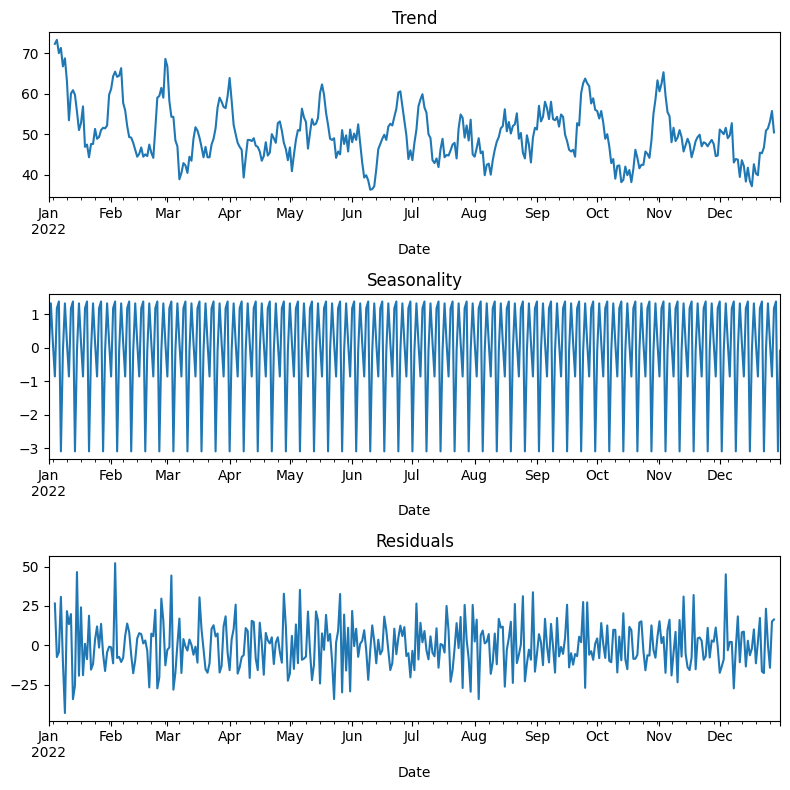

In [ ]:
#make decomposition
decomposed = seasonal_decompose(df_reg.set_index('Date')) #set feature 'Date' to be index

plt.figure(figsize=(8,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

The possible pattern of seasonality is once a week.

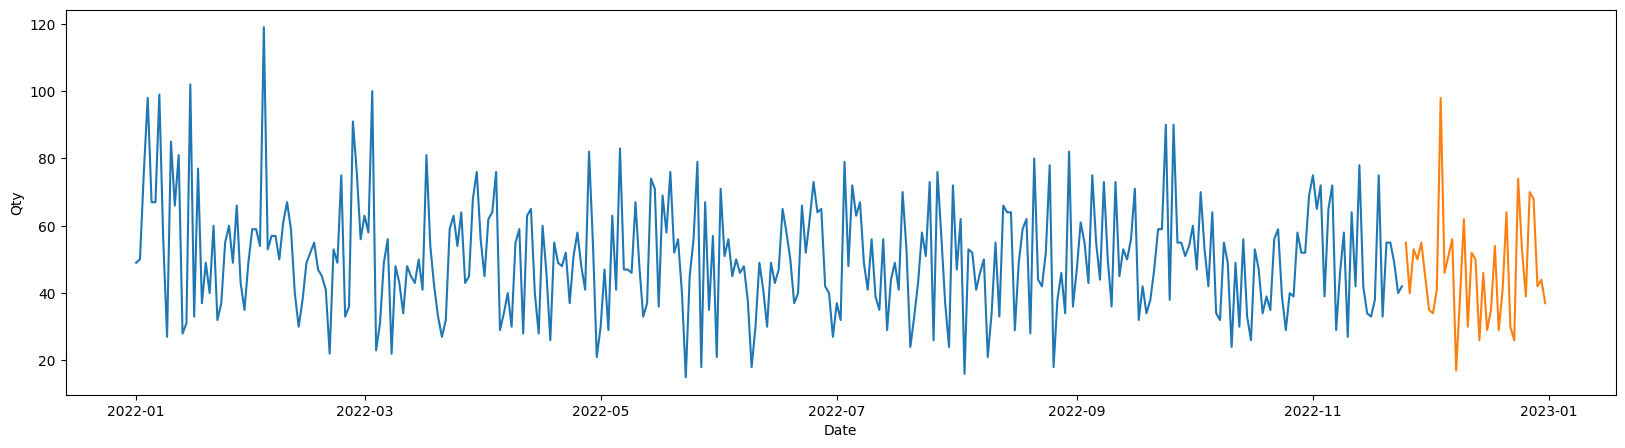

In [ ]:
#split data train and data test
cut_off = round(df_reg.shape[0] * 0.9) #for splitting in time series, can't used method random_state
df_train = df_reg[:cut_off]
df_test = df_reg[cut_off:].reset_index(drop=True) #drop=True for dropping col index

#plot data train and data test
plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x='Date', y='Qty')
sns.lineplot(data=df_test, x='Date', y='Qty')
plt.show()

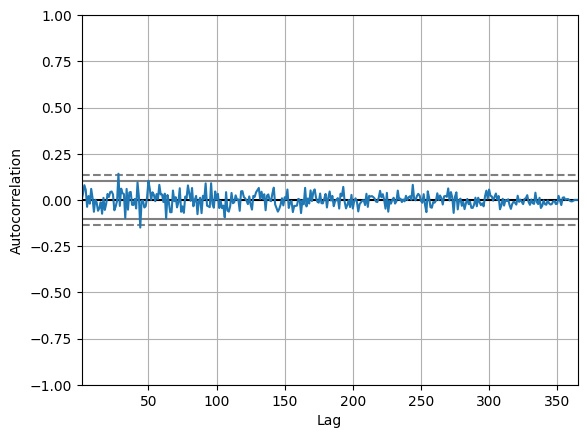

In [ ]:
#autocorrelation
autocorrelation_plot(df_reg['Qty'])
plt.show()

In [ ]:
#function of evaluation metrics score
def eval(y_actual, y_predict):
    rmse = mean_squared_error(y_actual, y_predict)**0.5
    mae = mean_absolute_error(y_actual, y_predict)
    r2 = r2_score(y_actual, y_predict)

    print(f'RMSE value: {rmse}')
    print(f'MAE value: {mae}')
    print(f'R-squared value: {r2}')

RMSE value: 16.491664059691274
MAE value: 12.920707883864068
R-squared value: -0.11283923830954934


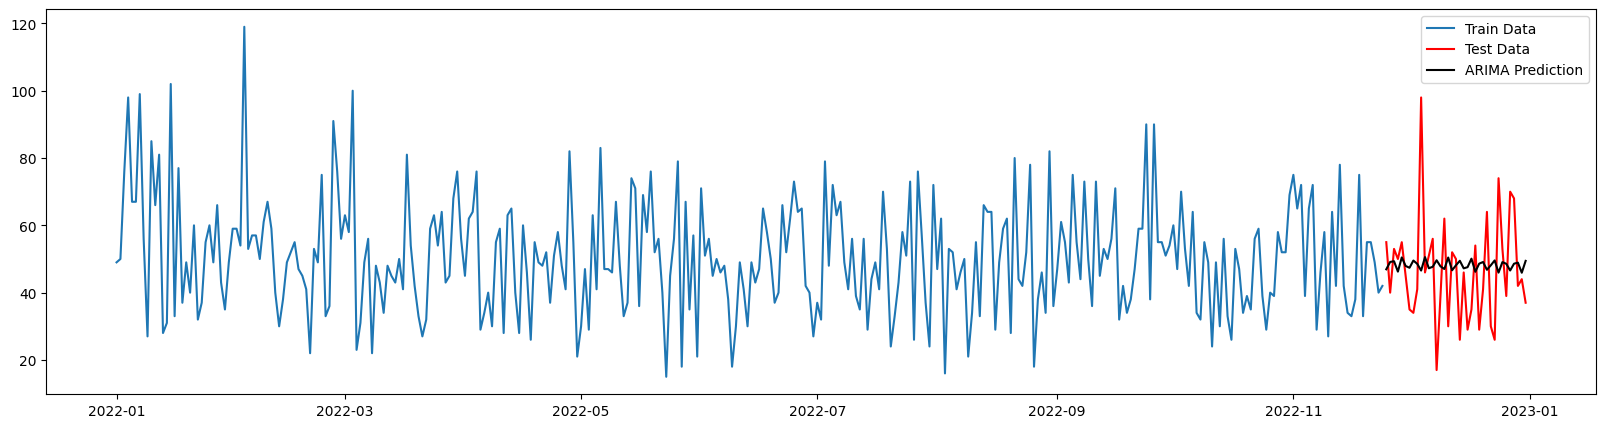

In [ ]:
#ARIMA
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

y = df_train['Qty']

arima = ARIMA(y, order=(5,2,5))
arima = arima.fit()

y_pred = arima.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['prediction'] = arima.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['prediction']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20,5))
plt.plot(df_train['Qty'], label='Train Data')
plt.plot(df_test['Qty'], color='red', label='Test Data')
plt.plot(y_pred_out, color='black', label='ARIMA Prediction')
plt.legend(loc='best')
plt.show()

###Hyperparameter Tuning

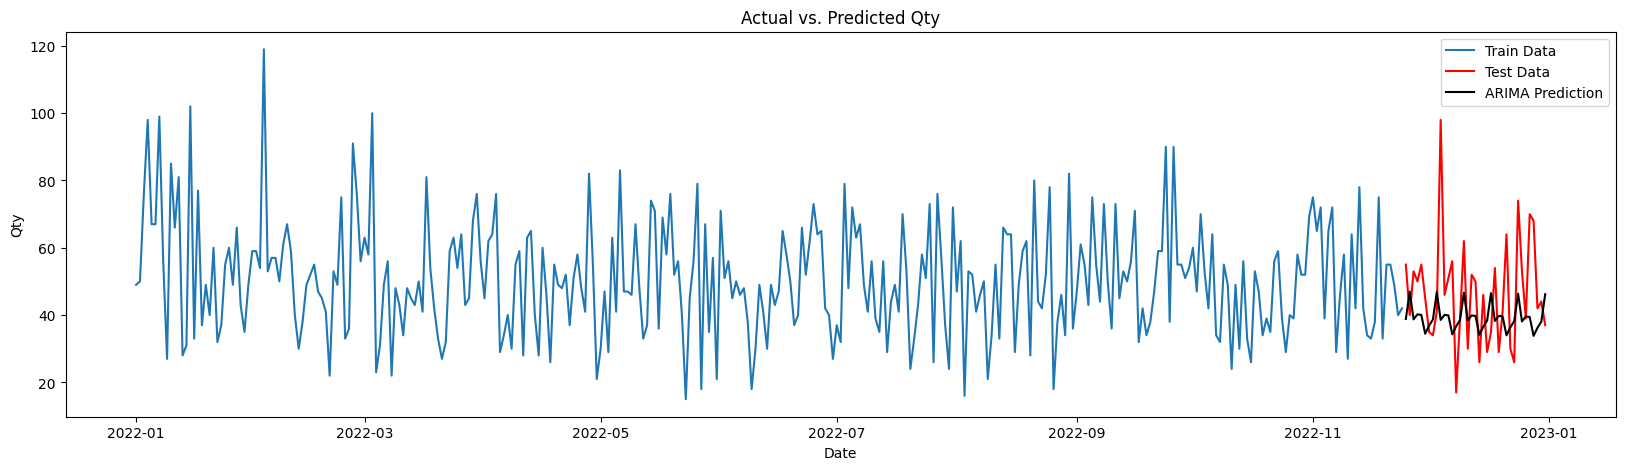

Best Hyperparameters: p=5, d=1, q=3, P=0, D=1, Q=1
Best RMSE: 15.042661961894384
Best MAE: 11.687693724854412
Best R2: 0.07412392129278711


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product

# Define the ranges for hyperparameter tuning
p_values = range(0, 6)  # 0, 1, 2, 3, 4, 5
d_values = range(0, 3)  # 0, 1, 2
q_values = range(0, 6)  # 0, 1, 2, 3, 4, 5
P_values = range(0, 2)  # 0, 1
D_values = range(0, 2)  # 0, 1
Q_values = range(0, 2)  # 0, 1

# Convert the 'Qty' column of the DataFrame to a numpy array
y = df_reg['Qty'].values

# Split the data into training and validation sets
train_size = int(len(y) * 0.9)
train, valid = y[:train_size], y[train_size:]

# Perform grid search for hyperparameter tuning
best_rmse = float('inf')
best_params = None

for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
    try:
        # Fit the ARIMA model with the current hyperparameters
        model = ARIMA(train, order=(p, d, q), seasonal_order=(P, D, Q, 7))
        model_fit = model.fit()

        # Make predictions on the validation set
        y_pred = model_fit.forecast(steps=len(valid))

        # Calculate evaluation metrics for the current hyperparameters
        rmse = np.sqrt(mean_squared_error(valid, y_pred))
        mae = mean_absolute_error(valid, y_pred)
        r2 = r2_score(valid, y_pred)

        # Update the best hyperparameters if the current RMSE is lower
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (p, d, q, P, D, Q)
            best_mae = mae
            best_r2 = r2
    except:
        continue

# Fit the ARIMA model with the best hyperparameters
best_model = ARIMA(y, order=(best_params[0], best_params[1], best_params[2]),
                   seasonal_order=(best_params[3], best_params[4], best_params[5], 7))
best_model_fit = best_model.fit()

# Make predictions for the entire dataset
y_pred_all = best_model_fit.forecast(steps=len(y))

# Plot the actual vs. predicted values
plt.figure(figsize=(20,5))
plt.plot(df_train['Qty'], label='Train Data')
plt.plot(df_test['Qty'], color='red', label='Test Data')
plt.plot(df_reg['Date'][train_size:], y_pred_all[train_size:], color='black', label='ARIMA Prediction')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Actual vs. Predicted Qty')
plt.show()

# Print the best hyperparameters and the corresponding evaluation metrics
print("Best Hyperparameters: p={}, d={}, q={}, P={}, D={}, Q={}".format(*best_params))
print("Best RMSE:", best_rmse)
print("Best MAE:", best_mae)
print("Best R2:", best_r2)

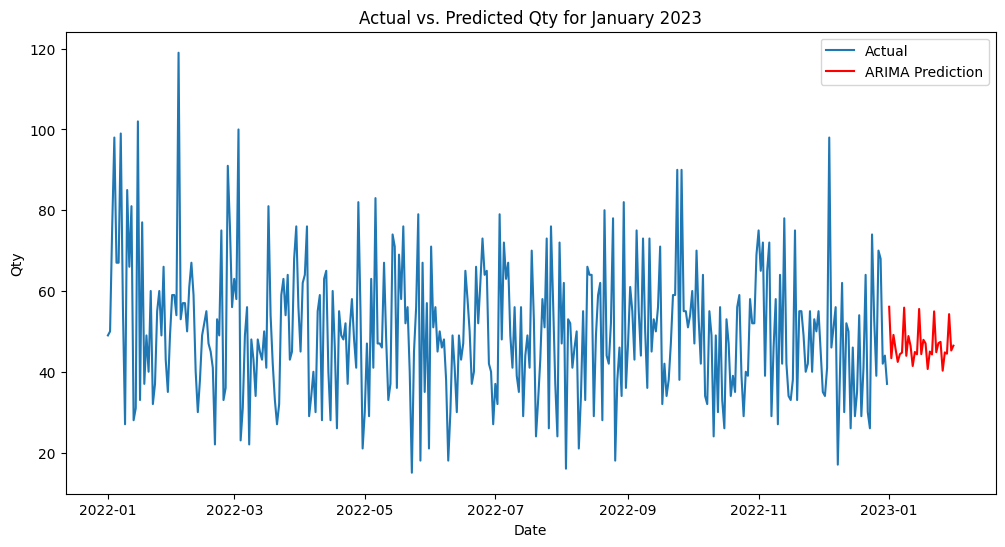

Prediction of Total Quantity Product Needs in January 2023 : 1446.0


In [ ]:
# You may need to set the 'Date' column as the index if it's not already set

# Convert the 'Qty' column of the DataFrame to a numpy array
y = df_reg['Qty'].values

# Re-fit the ARIMA model with the best hyperparameters using the entire dataset
best_model = ARIMA(y, order=(best_params[0], best_params[1], best_params[2]),
                   seasonal_order=(best_params[3], best_params[4], best_params[5], 7))
best_model_fit = best_model.fit()

# Forecast daily quantity needs for January 2023
forecast_period = 31  # Number of days in January 2023
y_pred_next_month = best_model_fit.forecast(steps=forecast_period)

# Generate date index for January 2023
date_index_jan_2023 = pd.date_range(start='2023-01-01', periods=forecast_period, freq='D')

# Create a DataFrame to store the predictions
df_pred_jan_2023 = pd.DataFrame({'Date': date_index_jan_2023, 'Predicted_Qty': y_pred_next_month})

# Plot the predicted quantity needs for January 2023
plt.figure(figsize=(12, 6))
plt.plot(df_reg['Date'], y, label='Actual')
plt.plot(df_pred_jan_2023['Date'], y_pred_next_month, color='red', label='ARIMA Prediction')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Actual vs. Predicted Qty for January 2023')
plt.show()

# Print the predicted quantity needs for January 2023
print('Prediction of Total Quantity Product Needs in January 2023 :', round(df_pred_jan_2023['Predicted_Qty'].sum(),0))